<a href="https://colab.research.google.com/github/vvattipallly/ML/blob/main/Gesture_Recognition_Final_VV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition - Ankita Bhatt & Vinod Vattipally
In this group project, we are going to build mutliple models that will be able to predict the 5 gestures correctly. 

Prerequisite for this code to work is to install scipy.misc v 1.1.0

This code has been written and compiled in Google Colab. Data folder is loaded as Project_data under root of the Google Drive\ My Drive. Any change to this location, need a code revision

Lets import the following libraries to get started.

In [1]:
pip install scipy==1.1.0

     |████████████████████████████████| 31.2 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.2.25 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [4]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [6]:
from google.colab import drive
drive.mount('/content/drive')
project_folder='/content/drive/MyDrive/Project_data'

Mounted at /content/drive


##### Plotting

In [7]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [9]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

##### Sample Cropping

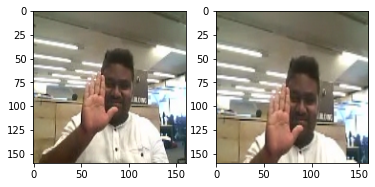

In [11]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

![image.png](attachment:image.png)

## Experimenting with Image resolution, number of frames to use and batch_size

In [12]:
#conv_3d1.train_model(conv_3d1_model)

### We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [13]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [14]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.6319 - categorical_accuracy: 0.3937  
Epoch 00001: saving model to model_init_2022-01-1407_06_48.001166/model-00001-1.63192-0.39367-3.32782-0.16000.h5
23/23 [==============================] - 5503s 250s/step - loss: 1.6319 - categorical_accuracy: 0.3937 - val_loss: 3.3278 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/3
22/23 [===========================>..] - ETA: 2s - loss: 0.9693 - categorical_accuracy: 0.6303
Epoch 00002: saving model to model_init_2022-01-1407_06_48.001166/model-00002-0.97306-0.63047-7.27045-0.16000.h5
23/23 [==============================] - 54s 2s/step - loss: 0.9731 - categorical_accuracy: 0.6305 - val_loss: 7.2705 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 0.8445 - categorical_accuracy: 0.6757
Epoch 00003: saving model to model_init_2022-01-1407_06_48.001166/model-00003-0.84455-0.67572-9.777

In [15]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.7996 - categorical_accuracy: 0.3695  
Epoch 00001: saving model to model_init_2022-01-1408_44_10.176051/model-00001-1.79965-0.36953-2.11970-0.16000.h5
23/23 [==============================] - 4892s 222s/step - loss: 1.7996 - categorical_accuracy: 0.3695 - val_loss: 2.1197 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.0867 - categorical_accuracy: 0.5882
Epoch 00002: saving model to model_init_2022-01-1408_44_10.176051/model-00002-1.08667-0.58824-3.67702-0.19000.h5
23/23 [==============================] - 91s 4s/step - loss: 1.0867 - categorical_accuracy: 0.5882 - val_loss: 3.6770 - val_categorical_accuracy: 0.1900 - lr: 0.0010


In [16]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
11/12 [==========================>...] - ETA: 6s - loss: 1.8450 - categorical_accuracy: 0.3621 
Epoch 00001: saving model to model_init_2022-01-1410_10_43.274084/model-00001-1.83838-0.36501-1.86945-0.16000.h5
12/12 [==============================] - 92s 8s/step - loss: 1.8384 - categorical_accuracy: 0.3650 - val_loss: 1.8695 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 1.1515 - categorical_accuracy: 0.5339
Epoch 00002: saving model to model_init_2022-01-1410_10_43.274084/model-00002-1.15151-0.53394-3.63457-0.11000.h5
12/12 [==============================] - 88s 8s/step - loss: 1.1515 - categorical_accuracy: 0.5339 - val_loss: 3.6346 - val_categorical_accuracy: 0.1100 - lr: 0.0010


In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.6031 - categorical_accuracy: 0.4057
Epoch 00001: saving model to model_init_2022-01-1410_13_51.226095/model-00001-1.60307-0.40573-1.54581-0.27000.h5
12/12 [==============================] - 50s 4s/step - loss: 1.6031 - categorical_accuracy: 0.4057 - val_loss: 1.5458 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 1.0712 - categorical_accuracy: 0.5913
Epoch 00002: saving model to model_init_2022-01-1410_13_51.226095/model-00002-1.07117-0.59125-2.04726-0.13000.h5
12/12 [==============================] - 47s 4s/step - loss: 1.0712 - categorical_accuracy: 0.5913 - val_loss: 2.0473 - val_categorical_accuracy: 0.1300 - lr: 0.0010


In [18]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 1.8699 - categorical_accuracy: 0.3167
Epoch 00001: saving model to model_init_2022-01-1410_15_32.286639/model-00001-1.86988-0.31674-1.65999-0.16000.h5
9/9 [==============================] - 52s 6s/step - loss: 1.8699 - categorical_accuracy: 0.3167 - val_loss: 1.6600 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
9/9 [==============================] - ETA: 0s - loss: 1.1993 - categorical_accuracy: 0.5490
Epoch 00002: saving model to model_init_2022-01-1410_15_32.286639/model-00002-1.19927-0.54902-2.34283-0.18000.h5
9/9 [==============================] - 45s 6s/step - loss: 1.1993 - categorical_accuracy: 0.5490 - val_loss: 2.3428 - val_categorical_accuracy: 0.1800 - lr: 0.0010


In [19]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5820 - categorical_accuracy: 0.3997
Epoch 00001: saving model to model_init_2022-01-1410_17_13.984737/model-00001-1.58197-0.39970-7.32283-0.21000.h5
45/45 [==============================] - 99s 2s/step - loss: 1.5820 - categorical_accuracy: 0.3997 - val_loss: 7.3228 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.2612 - categorical_accuracy: 0.4977
Epoch 00002: saving model to model_init_2022-01-1410_17_13.984737/model-00002-1.26121-0.49774-13.94081-0.23000.h5
45/45 [==============================] - 97s 2s/step - loss: 1.2612 - categorical_accuracy: 0.4977 - val_loss: 13.9408 - val_categorical_accuracy: 0.2300 - lr: 0.0010


In [20]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
44/45 [============================>.] - ETA: 1s - loss: 1.6508 - categorical_accuracy: 0.3742
Epoch 00001: saving model to model_init_2022-01-1410_20_32.459774/model-00001-1.64508-0.37707-3.65504-0.16000.h5
45/45 [==============================] - 55s 1s/step - loss: 1.6451 - categorical_accuracy: 0.3771 - val_loss: 3.6550 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0796 - categorical_accuracy: 0.5852
Epoch 00002: saving model to model_init_2022-01-1410_20_32.459774/model-00002-1.07963-0.58522-7.78751-0.14000.h5
45/45 [==============================] - 53s 1s/step - loss: 1.0796 - categorical_accuracy: 0.5852 - val_loss: 7.7875 - val_categorical_accuracy: 0.1400 - lr: 0.0010


In [21]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.6806 - categorical_accuracy: 0.3786
Epoch 00001: saving model to model_init_2022-01-1410_22_21.673646/model-00001-1.68056-0.37858-3.68778-0.16000.h5
45/45 [==============================] - 49s 1s/step - loss: 1.6806 - categorical_accuracy: 0.3786 - val_loss: 3.6878 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.1963 - categorical_accuracy: 0.5279
Epoch 00002: saving model to model_init_2022-01-1410_22_21.673646/model-00002-1.19630-0.52790-4.91420-0.15000.h5
45/45 [==============================] - 48s 1s/step - loss: 1.1963 - categorical_accuracy: 0.5279 - val_loss: 4.9142 - val_categorical_accuracy: 0.1500 - lr: 0.0010


In [22]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.8707 - categorical_accuracy: 0.3379
Epoch 00001: saving model to model_init_2022-01-1410_24_00.339740/model-00001-1.87065-0.33786-4.31520-0.16000.h5
67/67 [==============================] - 50s 736ms/step - loss: 1.8707 - categorical_accuracy: 0.3379 - val_loss: 4.3152 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.3231 - categorical_accuracy: 0.4646
Epoch 00002: saving model to model_init_2022-01-1410_24_00.339740/model-00002-1.32311-0.46456-6.18897-0.26000.h5
67/67 [==============================] - 49s 739ms/step - loss: 1.3231 - categorical_accuracy: 0.4646 - val_loss: 6.1890 - val_categorical_accuracy: 0.2600 - lr: 0.0010


In [23]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6988 - categorical_accuracy: 0.3439
Epoch 00001: saving model to model_init_2022-01-1410_25_39.771331/model-00001-1.69879-0.34389-3.52037-0.16000.h5
67/67 [==============================] - 91s 1s/step - loss: 1.6988 - categorical_accuracy: 0.3439 - val_loss: 3.5204 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.2417 - categorical_accuracy: 0.5023
Epoch 00002: saving model to model_init_2022-01-1410_25_39.771331/model-00002-1.24171-0.50226-5.28362-0.15000.h5
67/67 [==============================] - 90s 1s/step - loss: 1.2417 - categorical_accuracy: 0.5023 - val_loss: 5.2836 - val_categorical_accuracy: 0.1500 - lr: 0.0010


In [24]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6349 - categorical_accuracy: 0.4299
Epoch 00001: saving model to model_init_2022-01-1410_28_42.237155/model-00001-1.63495-0.42986-1.91055-0.28000.h5
67/67 [==============================] - 99s 1s/step - loss: 1.6349 - categorical_accuracy: 0.4299 - val_loss: 1.9106 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.1679 - categorical_accuracy: 0.5626
Epoch 00002: saving model to model_init_2022-01-1410_28_42.237155/model-00002-1.16792-0.56259-5.30529-0.16000.h5
67/67 [==============================] - 98s 1s/step - loss: 1.1679 - categorical_accuracy: 0.5626 - val_loss: 5.3053 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [25]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.7040 - categorical_accuracy: 0.4027
Epoch 00001: saving model to model_init_2022-01-1410_32_01.139717/model-00001-1.70402-0.40271-15.01098-0.16000.h5
67/67 [==============================] - 55s 810ms/step - loss: 1.7040 - categorical_accuracy: 0.4027 - val_loss: 15.0110 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.2386 - categorical_accuracy: 0.5264
Epoch 00002: saving model to model_init_2022-01-1410_32_01.139717/model-00002-1.23858-0.52640-12.79945-0.15000.h5
67/67 [==============================] - 53s 801ms/step - loss: 1.2386 - categorical_accuracy: 0.5264 - val_loss: 12.7995 - val_categorical_accuracy: 0.1500 - lr: 0.0010


In [26]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
17/17 [==============================] - ETA: 0s - loss: 1.4841 - categorical_accuracy: 0.4193
Epoch 00001: saving model to model_init_2022-01-1410_33_49.836519/model-00001-1.48412-0.41931-1.94247-0.21000.h5
17/17 [==============================] - 56s 3s/step - loss: 1.4841 - categorical_accuracy: 0.4193 - val_loss: 1.9425 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 1.0304 - categorical_accuracy: 0.5882
Epoch 00002: saving model to model_init_2022-01-1410_33_49.836519/model-00002-1.03040-0.58824-4.20589-0.22000.h5
17/17 [==============================] - 53s 3s/step - loss: 1.0304 - categorical_accuracy: 0.5882 - val_loss: 4.2059 - val_categorical_accuracy: 0.2200 - lr: 0.0010


##### As we see from the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size

##### So experimentations are carried with batch size fixed around 15-40 and changing the resolution and number of image per sequence based on the device memory constraints . Models are designed such that their memory foot print is less than 50 MB which corresponds to 4.3 million parameters assuming the datatype size of parameters to be 12 bytes

# Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [27]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [28]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_56 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_84 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_57 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_57 (Activation)  (None, 10, 80, 80, 32)  

In [29]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.6165 - categorical_accuracy: 0.3906
Epoch 00001: saving model to model_init_2022-01-1410_35_41.692730/model-00001-1.61654-0.39065-1.58010-0.33000.h5
17/17 [==============================] - 70s 4s/step - loss: 1.6165 - categorical_accuracy: 0.3906 - val_loss: 1.5801 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.0379 - categorical_accuracy: 0.6094
Epoch 00002: saving model to model_init_2022-01-1410_35_41.692730/model-00002-1.03792-0.60935-2.32298-0.27000.h5
17/17 [==============================] - 67s 4s/step - loss: 1.0379 - categorical_accuracy: 0.6094 - val_loss: 2.3230 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.7769 - categorical_accuracy: 0.6953
Epoch 00003: saving model to model_init_2022-01-1410_35_41.692730/model-00003-0.77694-0.69532-2.60911-

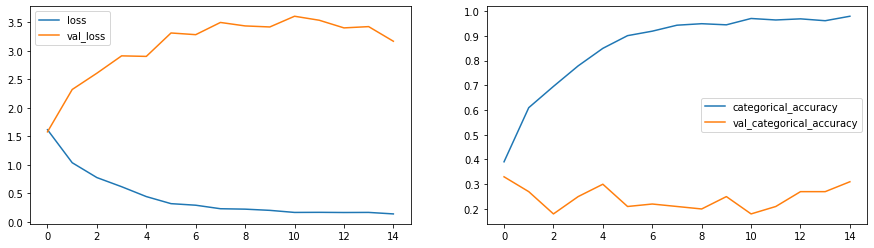

In [30]:
plot(history_model1)

##### Model is clearly overfitting. So we need to do data augmentation

# Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [31]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_60 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_90 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_60 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_61 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_61 (Activation)  (None, 10, 80, 80, 32)  

In [32]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9656 - categorical_accuracy: 0.3869
Epoch 00001: saving model to model_init_2022-01-1410_52_21.391542/model-00001-1.96559-0.38688-1.73299-0.26000.h5
34/34 [==============================] - 116s 3s/step - loss: 1.9656 - categorical_accuracy: 0.3869 - val_loss: 1.7330 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6708 - categorical_accuracy: 0.4449
Epoch 00002: saving model to model_init_2022-01-1410_52_21.391542/model-00002-1.67077-0.44495-4.62642-0.15000.h5
34/34 [==============================] - 114s 3s/step - loss: 1.6708 - categorical_accuracy: 0.4449 - val_loss: 4.6264 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.4513 - categorical_accuracy: 0.4962
Epoch 00003: saving model to model_init_2022-01-1410_52_21.391542/model-00003-1.45135-0.49623-4.5484

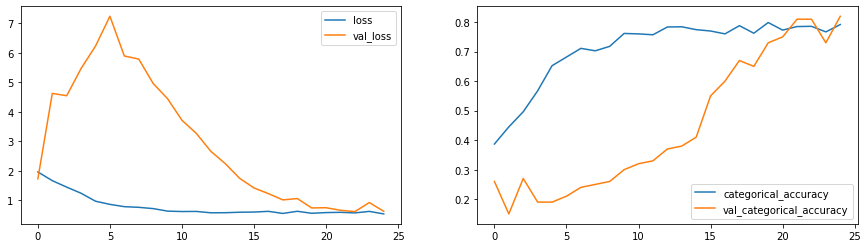

In [33]:
plot(history_model2)

##### Model is not overfitting and we get a best validation accuracy of 82% and training accuracy of 79%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

# Model 3 - Reduce filter size to (2,2,2) and image res to 120 x  120

In [34]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_64 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_64 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_96 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_64 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_65 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_65 (Activation)  (None, 8, 60, 60, 32)   

In [36]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.1918 - categorical_accuracy: 0.3160
Epoch 00001: saving model to model_init_2022-01-1411_39_56.285902/model-00001-2.19175-0.31599-1.75640-0.16000.h5
23/23 [==============================] - 82s 4s/step - loss: 2.1918 - categorical_accuracy: 0.3160 - val_loss: 1.7564 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.4785 - categorical_accuracy: 0.4894
Epoch 00002: saving model to model_init_2022-01-1411_39_56.285902/model-00002-1.47848-0.48944-2.51304-0.21000.h5
23/23 [==============================] - 82s 4s/step - loss: 1.4785 - categorical_accuracy: 0.4894 - val_loss: 2.5130 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.2810 - categorical_accuracy: 0.5528
Epoch 00003: saving model to model_init_2022-01-1411_39_56.285902/model-00003-1.28098-0.55279-

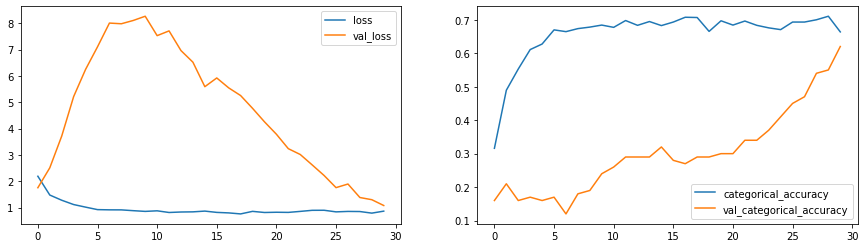

In [37]:
plot(history_model3)

##### Model has a  best validation accuracy of 62% and training accuracy of 69% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

# Model 4 - Adding more layers

In [38]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [39]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_68 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_102 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_69 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_69 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_103 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [40]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.0742 - categorical_accuracy: 0.3265
Epoch 00001: saving model to model_init_2022-01-1412_20_54.700918/model-00001-2.07420-0.32655-2.91004-0.16000.h5
34/34 [==============================] - 86s 2s/step - loss: 2.0742 - categorical_accuracy: 0.3265 - val_loss: 2.9100 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6348 - categorical_accuracy: 0.4359
Epoch 00002: saving model to model_init_2022-01-1412_20_54.700918/model-00002-1.63477-0.43590-4.54432-0.19000.h5
34/34 [==============================] - 84s 3s/step - loss: 1.6348 - categorical_accuracy: 0.4359 - val_loss: 4.5443 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.3932 - categorical_accuracy: 0.5181
Epoch 00003: saving model to model_init_2022-01-1412_20_54.700918/model-00003-1.39323-0.51810-7.02556-

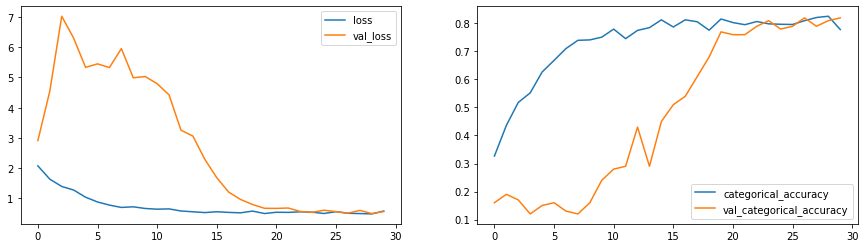

In [41]:
plot(history_model4)

##### With more layers we dont see much performance improvement. We get a best validation accuracy of 82% . Let's try adding dropouts at the convolution layers

# Model 5 Adding dropout at convolution layers

In [42]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [43]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_76 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_76 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_112 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_77 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_77 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_113 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [44]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - ETA: 0s - loss: 1.7273 - categorical_accuracy: 0.3914
Epoch 00001: saving model to model_init_2022-01-1413_03_11.853962/model-00001-1.72735-0.39140-1.82750-0.21000.h5
34/34 [==============================] - 86s 3s/step - loss: 1.7273 - categorical_accuracy: 0.3914 - val_loss: 1.8275 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/22
34/34 [==============================] - ETA: 0s - loss: 1.4185 - categorical_accuracy: 0.4827
Epoch 00002: saving model to model_init_2022-01-1413_03_11.853962/model-00002-1.41850-0.48265-1.92903-0.19000.h5
34/34 [==============================] - 84s 3s/step - loss: 1.4185 - categorical_accuracy: 0.4827 - val_loss: 1.9290 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/22
34/34 [==============================] - ETA: 0s - loss: 1.1818 - categorical_accuracy: 0.5694
Epoch 00003: saving model to model_init_2022-01-1413_03_11.853962/model-00003-1.18182-0.56938-2.75826-

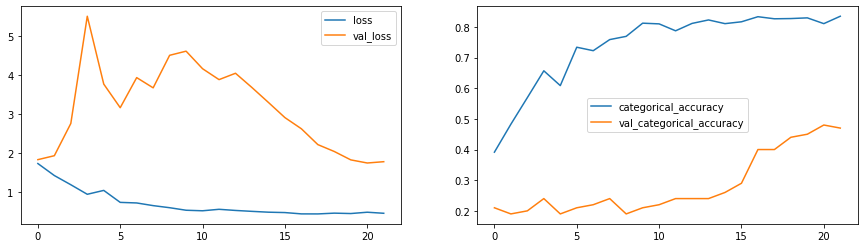

In [45]:
plot(history_model5)

##### Adding dropouts has further reduced validation accuracy as its not to learn  generalizable features

##### All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

# Model 6 - reducing the number of parameters

In [46]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [47]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_84 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_84 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_122 (Ba  (None, 16, 100, 100, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_76 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_85 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_85 (Activation)  (None, 8, 50, 50, 32)   

In [48]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8429 - categorical_accuracy: 0.3416
Epoch 00001: saving model to model_init_2022-01-1413_33_53.038614/model-00001-1.84289-0.34163-1.88225-0.16000.h5
34/34 [==============================] - 81s 2s/step - loss: 1.8429 - categorical_accuracy: 0.3416 - val_loss: 1.8822 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.2393 - categorical_accuracy: 0.5090
Epoch 00002: saving model to model_init_2022-01-1413_33_53.038614/model-00002-1.23931-0.50905-2.91658-0.17000.h5
34/34 [==============================] - 81s 2s/step - loss: 1.2393 - categorical_accuracy: 0.5090 - val_loss: 2.9166 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.0532 - categorical_accuracy: 0.5814
Epoch 00003: saving model to model_init_2022-01-1413_33_53.038614/model-00003-1.05316-0.58145-3

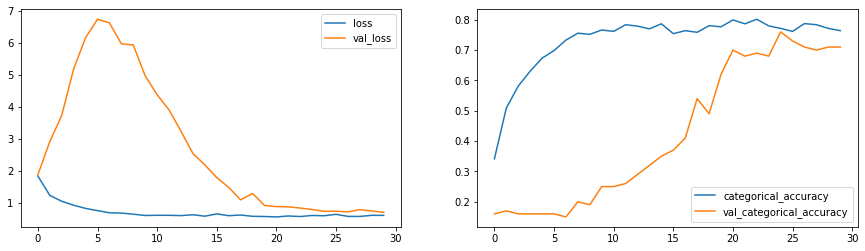

In [49]:
plot(history_model6)

###### For the above low memory foot print model the best validation accuracy of 76%

# Model 7 - reducing the number of parameters

In [50]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [51]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_88 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_88 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_128 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_80 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_89 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_89 (Activation)  (None, 8, 60, 60, 32)   

In [52]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
33/34 [============================>.] - ETA: 2s - loss: 1.8204 - categorical_accuracy: 0.3591
Epoch 00001: saving model to model_init_2022-01-1414_14_09.564114/model-00001-1.82057-0.35747-2.41788-0.16000.h5
34/34 [==============================] - 84s 3s/step - loss: 1.8206 - categorical_accuracy: 0.3575 - val_loss: 2.4179 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
33/34 [============================>.] - ETA: 2s - loss: 1.2110 - categorical_accuracy: 0.5508
Epoch 00002: saving model to model_init_2022-01-1414_14_09.564114/model-00002-1.21263-0.54902-4.14911-0.20000.h5
34/34 [==============================] - 83s 3s/step - loss: 1.2126 - categorical_accuracy: 0.5490 - val_loss: 4.1491 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/25
33/34 [============================>.] - ETA: 2s - loss: 1.0558 - categorical_accuracy: 0.6061
Epoch 00003: saving model to model_init_2022-01-1414_14_09.564114/model-00003-1.05532-0.60558-6

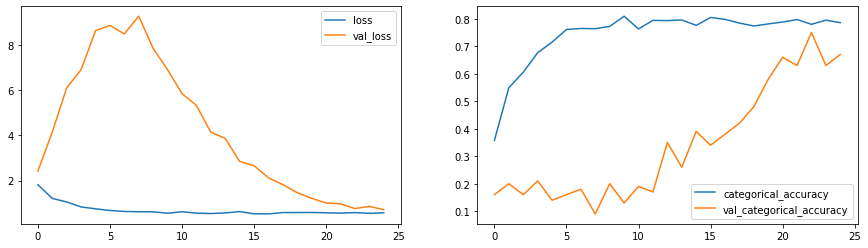

In [53]:
plot(history_model7)

###### For the above low memory foot print model the best validation accuracy of 75%

# Model 8 - reducing the number of parameters

In [54]:
class ModelConv3D8(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [55]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_92 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 activation_92 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 batch_normalization_134 (Ba  (None, 16, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_84 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_93 (Conv3D)          (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_93 (Activation)  (None, 8, 60, 60, 16)   

In [56]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9622 - categorical_accuracy: 0.2926
Epoch 00001: saving model to model_init_2022-01-1414_48_37.604195/model-00001-1.96220-0.29261-1.71754-0.16000.h5
34/34 [==============================] - 86s 3s/step - loss: 1.9622 - categorical_accuracy: 0.2926 - val_loss: 1.7175 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4804 - categorical_accuracy: 0.4578
Epoch 00002: saving model to model_init_2022-01-1414_48_37.604195/model-00002-1.48043-0.45777-2.07020-0.19000.h5
34/34 [==============================] - 82s 2s/step - loss: 1.4804 - categorical_accuracy: 0.4578 - val_loss: 2.0702 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.3005 - categorical_accuracy: 0.4955
Epoch 00003: saving model to model_init_2022-01-1414_48_37.604195/model-00003-1.30045-0.49548-2

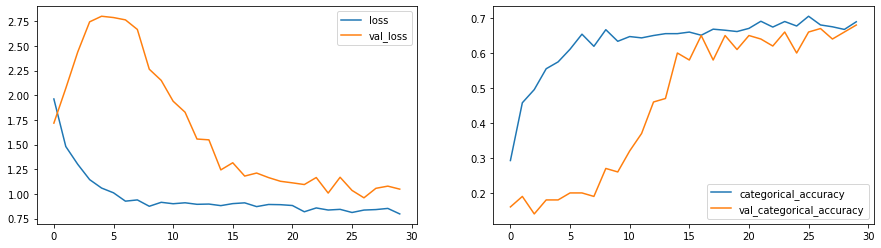

In [57]:
plot(history_model8)

###### For the above low memory foot print model the best validation accuracy of 68%

# Model 9 - CNN- LSTM Model

In [58]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [59]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32) 

In [60]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4413 - categorical_accuracy: 0.3914
Epoch 00001: saving model to model_init_2022-01-1415_30_33.312476/model-00001-1.44127-0.39140-1.68842-0.23000.h5
34/34 [==============================] - 98s 3s/step - loss: 1.4413 - categorical_accuracy: 0.3914 - val_loss: 1.6884 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1578 - categorical_accuracy: 0.5090
Epoch 00002: saving model to model_init_2022-01-1415_30_33.312476/model-00002-1.15781-0.50905-2.18660-0.13000.h5
34/34 [==============================] - 93s 3s/step - loss: 1.1578 - categorical_accuracy: 0.5090 - val_loss: 2.1866 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9450 - categorical_accuracy: 0.6388
Epoch 00003: saving model to model_init_2022-01-1415_30_33.312476/model-00003-0.94500-0.63876-2.15604-

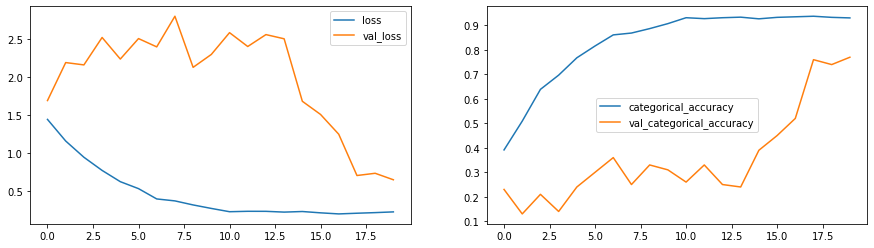

In [61]:
plot(history_model9)

##### For CNN - LSTM model we get a best validation accuracy of 77%

### As we see more cases of overfitting, lets augment the data with slight rotation as well and run the same set of models again

# More Augmentation

In [62]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [63]:
#class Test(ModelBuilderMoreAugmentation):
#    def define_model(self):
#        pass

#test_generator=Test()
#test_generator.initialize_path(project_folder)
#test_generator.initialize_image_properties(image_height=160,image_width=160)
#test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

#g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
#batch_data, batch_labels=next(g)
#fig, axes = plt.subplots(nrows=1, ncols=2)
#axes[0].imshow(batch_data[0,29,:,:,:])   
#axes[1].imshow(batch_data[3,29,:,:,:])   

# Model 10 - (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [64]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [65]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=160,image_width=160)
conv_3d10.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_96 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_96 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_145 (Ba  (None, 20, 160, 160, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_88 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_97 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_97 (Activation)  (None, 10, 80, 80, 32)  

In [66]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 3638981
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.1043 - categorical_accuracy: 0.3394
Epoch 00001: saving model to model_init_2022-01-1416_01_57.094250/model-00001-2.10427-0.33937-2.48960-0.21000.h5
34/34 [==============================] - 120s 4s/step - loss: 2.1043 - categorical_accuracy: 0.3394 - val_loss: 2.4896 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6195 - categorical_accuracy: 0.4653
Epoch 00002: saving model to model_init_2022-01-1416_01_57.094250/model-00002-1.61955-0.46531-4.51476-0.18000.h5
34/34 [==============================] - 117s 4s/step - loss: 1.6195 - categorical_accuracy: 0.4653 - val_loss: 4.5148 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.3013 - categorical_accuracy: 0.5551
Epoch 00003: saving model to model_init_2022-01-1416_01_57.094250/model-00003-1.30126-0.5550

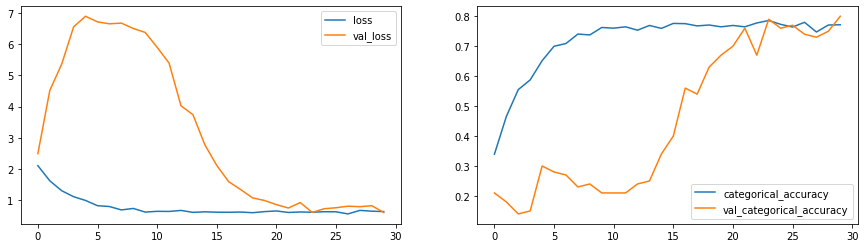

In [67]:
plot(history_model10)


##### As we can see in this model the validation accuracy is improved to 80%. Also the model is not overfitting as the relative Training accuracy is also approximately 77%

# Model 11 - (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [69]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [70]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_100 (Conv3D)         (None, 16, 120, 120, 16)  400       
                                                                 
 activation_100 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_151 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_92 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_101 (Conv3D)         (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_101 (Activation)  (None, 8, 60, 60, 32)  

In [71]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.0930 - categorical_accuracy: 0.3431
Epoch 00001: saving model to model_init_2022-01-1417_01_01.019267/model-00001-2.09302-0.34314-1.95651-0.16000.h5
23/23 [==============================] - 84s 4s/step - loss: 2.0930 - categorical_accuracy: 0.3431 - val_loss: 1.9565 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
22/23 [===========================>..] - ETA: 3s - loss: 1.5621 - categorical_accuracy: 0.4553
Epoch 00002: saving model to model_init_2022-01-1417_01_01.019267/model-00002-1.56641-0.45475-3.46425-0.17000.h5
23/23 [==============================] - 84s 4s/step - loss: 1.5664 - categorical_accuracy: 0.4548 - val_loss: 3.4642 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.3508 - categorical_accuracy: 0.5241
Epoch 00003: saving model to model_init_2022-01-1417_01_01.019267/model-00003-1.35083-0.52413-

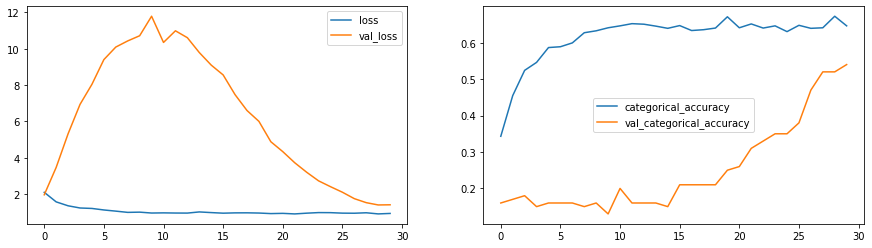

In [72]:
plot(history_model11)

#####As you can see the validation accuracy is really low. Hence we need not consider this model

# Model 12 - Adding more layers - Similar to model 4

In [73]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [74]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d12_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_104 (Conv3D)         (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_104 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_157 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_105 (Conv3D)         (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_105 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_158 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [75]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.1409 - categorical_accuracy: 0.3401
Epoch 00001: saving model to model_init_2022-01-1417_42_43.480962/model-00001-2.14086-0.34012-2.53315-0.21000.h5
34/34 [==============================] - 85s 3s/step - loss: 2.1409 - categorical_accuracy: 0.3401 - val_loss: 2.5332 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5908 - categorical_accuracy: 0.4517
Epoch 00002: saving model to model_init_2022-01-1417_42_43.480962/model-00002-1.59077-0.45173-3.95473-0.21000.h5
34/34 [==============================] - 84s 3s/step - loss: 1.5908 - categorical_accuracy: 0.4517 - val_loss: 3.9547 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.3220 - categorical_accuracy: 0.5339
Epoch 00003: saving model to model_init_2022-01-1417_42_43.480962/model-00003-1.32197-0.53394-

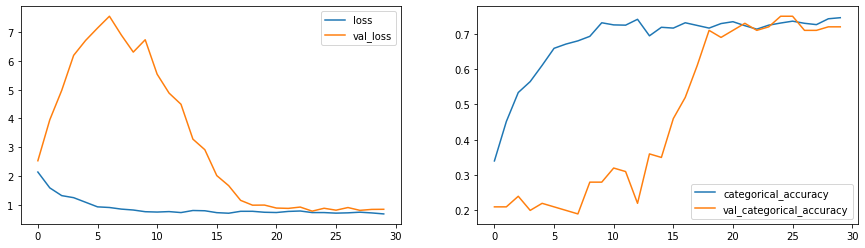

In [76]:
plot(history_model12)

##### Validation Accuracy for the above model is 75% with the relative Training Accuracy of 73%

# Model 13 - Adding dropouts - Similar to Model 5

In [77]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [78]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=120,image_width=120)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_112 (Conv3D)         (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_112 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_167 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_113 (Conv3D)         (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_113 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_168 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [79]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9640 - categorical_accuracy: 0.3130
Epoch 00001: saving model to model_init_2022-01-1418_24_55.731005/model-00001-1.96402-0.31297-2.52729-0.16000.h5
34/34 [==============================] - 87s 3s/step - loss: 1.9640 - categorical_accuracy: 0.3130 - val_loss: 2.5273 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5924 - categorical_accuracy: 0.4276
Epoch 00002: saving model to model_init_2022-01-1418_24_55.731005/model-00002-1.59238-0.42760-4.18499-0.12000.h5
34/34 [==============================] - 85s 3s/step - loss: 1.5924 - categorical_accuracy: 0.4276 - val_loss: 4.1850 - val_categorical_accuracy: 0.1200 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3979 - categorical_accuracy: 0.4721
Epoch 00003: saving model to model_init_2022-01-1418_24_55.731005/model-00003-1.39786-0.47210-

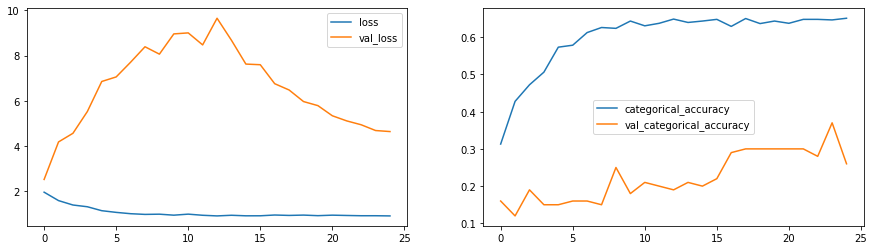

In [80]:
plot(history_model13)

#####As both Training and Validation accuracies are very less, we can disregard this model

# Model 14 - reducing network parameters - Similar to Model 6

In [81]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [82]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=100,image_width=100)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d14_model=conv_3d14.define_model(dense_neurons=128,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_120 (Conv3D)         (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_120 (Activation)  (None, 16, 100, 100, 16)  0        
                                                                 
 batch_normalization_177 (Ba  (None, 16, 100, 100, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_104 (MaxPooli  (None, 8, 50, 50, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_121 (Conv3D)         (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_121 (Activation)  (None, 8, 50, 50, 32)  

In [83]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8224 - categorical_accuracy: 0.3575
Epoch 00001: saving model to model_init_2022-01-1418_59_57.042671/model-00001-1.82243-0.35747-2.19816-0.25000.h5
34/34 [==============================] - 83s 2s/step - loss: 1.8224 - categorical_accuracy: 0.3575 - val_loss: 2.1982 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.1360 - categorical_accuracy: 0.5679
Epoch 00002: saving model to model_init_2022-01-1418_59_57.042671/model-00002-1.13600-0.56787-3.28091-0.19000.h5
34/34 [==============================] - 81s 2s/step - loss: 1.1360 - categorical_accuracy: 0.5679 - val_loss: 3.2809 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.0046 - categorical_accuracy: 0.6297
Epoch 00003: saving model to model_init_2022-01-1418_59_57.042671/model-00003-1.00458-0.62971-4

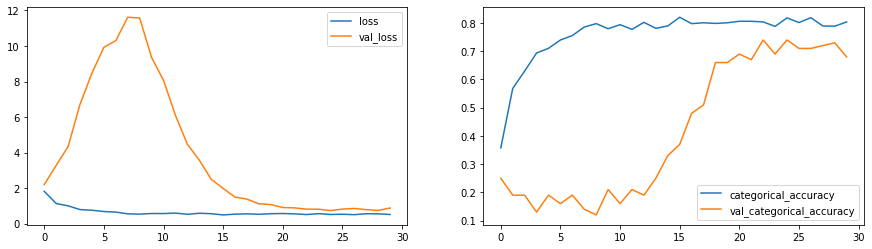

In [84]:
plot(history_model14)

#####Peak validation accuracy of this mode is 74% while the corresponding Training accuracy of 81% suggests a model over fitting still

# Model 15 - reducing network parameters - Similar to model 7

In [85]:
class ModelConv3D15(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [86]:
conv_3d15=ModelConv3D15()
conv_3d15.initialize_path(project_folder)
conv_3d15.initialize_image_properties(image_height=120,image_width=120)
conv_3d15.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d15_model=conv_3d15.define_model(dense_neurons=64,dropout=0.25)
conv_3d15_model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_124 (Conv3D)         (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_124 (Activation)  (None, 16, 120, 120, 16)  0        
                                                                 
 batch_normalization_183 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_108 (MaxPooli  (None, 8, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_125 (Conv3D)         (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_125 (Activation)  (None, 8, 60, 60, 32)  

In [87]:
print("Total Params:", conv_3d15_model.count_params())
history_model15=conv_3d15.train_model(conv_3d15_model,augment_data=True)

Total Params: 504709
Epoch 1/25
33/34 [============================>.] - ETA: 2s - loss: 1.7744 - categorical_accuracy: 0.3348
Epoch 00001: saving model to model_init_2022-01-1419_40_45.683386/model-00001-1.77402-0.33635-1.70345-0.16000.h5
34/34 [==============================] - 86s 3s/step - loss: 1.7740 - categorical_accuracy: 0.3363 - val_loss: 1.7035 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3458 - categorical_accuracy: 0.4857
Epoch 00002: saving model to model_init_2022-01-1419_40_45.683386/model-00002-1.34585-0.48567-2.05457-0.23000.h5
34/34 [==============================] - 85s 3s/step - loss: 1.3458 - categorical_accuracy: 0.4857 - val_loss: 2.0546 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0961 - categorical_accuracy: 0.5603
Epoch 00003: saving model to model_init_2022-01-1419_40_45.683386/model-00003-1.09614-0.56033-2

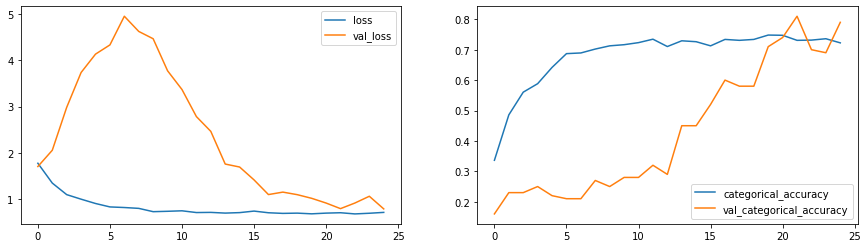

In [88]:
plot(history_model15)

#####Peak validation accuracy is 81% and the corresponding training accuracy is 74%

# Model 16 - reducing network parameters - Similar to Model 8

In [89]:
class ModelConv3D16(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [90]:
conv_3d16=ModelConv3D16()
conv_3d16.initialize_path(project_folder)
conv_3d16.initialize_image_properties(image_height=120,image_width=120)
conv_3d16.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d16_model=conv_3d16.define_model(dense_neurons=64,dropout=0.25)
conv_3d16_model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_128 (Conv3D)         (None, 16, 120, 120, 8)   656       
                                                                 
 activation_128 (Activation)  (None, 16, 120, 120, 8)  0         
                                                                 
 batch_normalization_189 (Ba  (None, 16, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_112 (MaxPooli  (None, 8, 60, 60, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_129 (Conv3D)         (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_129 (Activation)  (None, 8, 60, 60, 16)  

In [91]:
print("Total Params:", conv_3d16_model.count_params())
history_model16=conv_3d16.train_model(conv_3d16_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.0013 - categorical_accuracy: 0.3017
Epoch 00001: saving model to model_init_2022-01-1420_15_56.618153/model-00001-2.00126-0.30166-1.79959-0.16000.h5
34/34 [==============================] - 85s 3s/step - loss: 2.0013 - categorical_accuracy: 0.3017 - val_loss: 1.7996 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4399 - categorical_accuracy: 0.4457
Epoch 00002: saving model to model_init_2022-01-1420_15_56.618153/model-00002-1.43990-0.44570-2.33807-0.17000.h5
34/34 [==============================] - 84s 3s/step - loss: 1.4399 - categorical_accuracy: 0.4457 - val_loss: 2.3381 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.2334 - categorical_accuracy: 0.5143
Epoch 00003: saving model to model_init_2022-01-1420_15_56.618153/model-00003-1.23335-0.51433-3

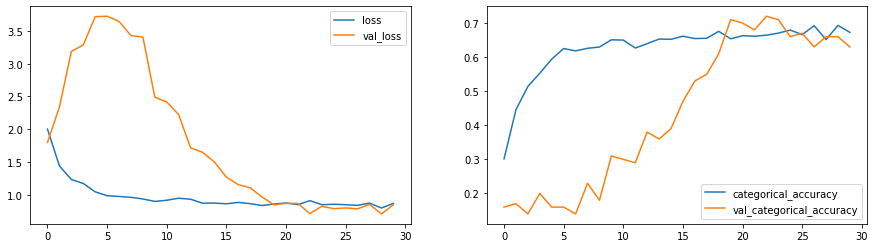

In [92]:
plot(history_model16)

#####Low training and vlaidation accuracies. Model can be disregarded

# Model 17 - CNN LSTM with GRU - Similar to Model 9

In [93]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [94]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 18, 60, 60, 32) 

In [95]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4492 - categorical_accuracy: 0.4035
Epoch 00001: saving model to model_init_2022-01-1420_57_47.192316/model-00001-1.44917-0.40347-1.68949-0.16000.h5
34/34 [==============================] - 98s 3s/step - loss: 1.4492 - categorical_accuracy: 0.4035 - val_loss: 1.6895 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0594 - categorical_accuracy: 0.5867
Epoch 00002: saving model to model_init_2022-01-1420_57_47.192316/model-00002-1.05935-0.58673-2.30981-0.17000.h5
34/34 [==============================] - 94s 3s/step - loss: 1.0594 - categorical_accuracy: 0.5867 - val_loss: 2.3098 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8799 - categorical_accuracy: 0.6652
Epoch 00003: saving model to model_init_2022-01-1420_57_47.192316/model-00003-0.87991-0.66516-

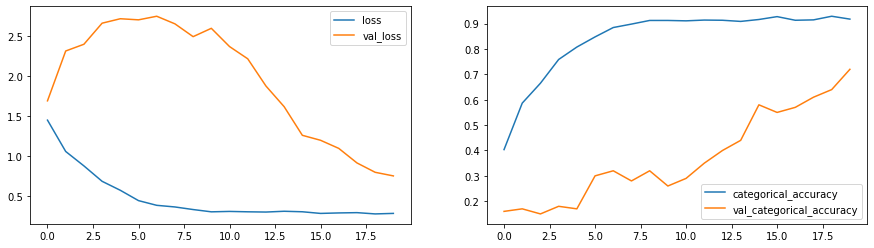

In [96]:
plot(history_model17)

#####Analysis goes here

### We see that overfitting is considerably less when we do more augmentation. However there is not much improvement on accuracy

# Model 18 - Transfer Learning

In [97]:
from keras.applications import mobilenet

In [98]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17235968/17225924 [==============================] - 0s 0us/step


In [99]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)             

In [100]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3273 - categorical_accuracy: 0.4389
Epoch 00001: saving model to model_init_2022-01-1421_29_45.324435/model-00001-1.32725-0.43891-0.96371-0.62000.h5
133/133 [==============================] - 91s 663ms/step - loss: 1.3273 - categorical_accuracy: 0.4389 - val_loss: 0.9637 - val_categorical_accuracy: 0.6200 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9063 - categorical_accuracy: 0.6425
Epoch 00002: saving model to model_init_2022-01-1421_29_45.324435/model-00002-0.90632-0.64253-0.70426-0.73000.h5
133/133 [==============================] - 87s 655ms/step - loss: 0.9063 - categorical_accuracy: 0.6425 - val_loss: 0.7043 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.6801 - categorical_accuracy: 0.7413
Epoch 00003: saving model to model_init_2022-01-1421_29_45.324435/model-00003-0.68013-

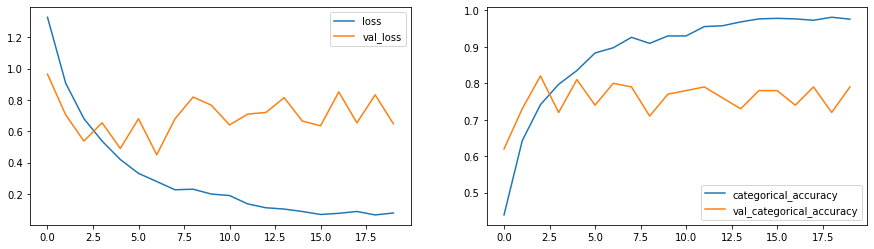

In [101]:
plot(history_model18)

##### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

# Model 19 - Transfer Learning with GRU and training all weights

In [102]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [103]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_33 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)             

In [104]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.1268 - categorical_accuracy: 0.5566
Epoch 00001: saving model to model_init_2022-01-1421_58_54.210504/model-00001-1.12684-0.55656-0.58438-0.79000.h5
133/133 [==============================] - 92s 660ms/step - loss: 1.1268 - categorical_accuracy: 0.5566 - val_loss: 0.5844 - val_categorical_accuracy: 0.7900 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.5943 - categorical_accuracy: 0.7730
Epoch 00002: saving model to model_init_2022-01-1421_58_54.210504/model-00002-0.59427-0.77300-0.31285-0.85000.h5
133/133 [==============================] - 86s 650ms/step - loss: 0.5943 - categorical_accuracy: 0.7730 - val_loss: 0.3128 - val_categorical_accuracy: 0.8500 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5103 - categorical_accuracy: 0.8152
Epoch 00003: saving model to model_init_2022-01-1421_58_54.210504/model-00003-0.51032-

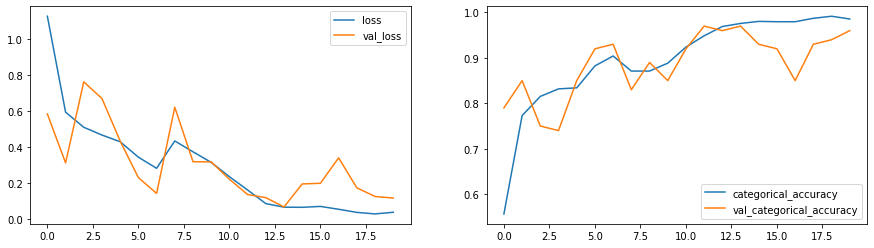

In [105]:
plot(history_model19)

# Consolidated Final Models

![image.png](attachment:image.png)

# Loading model and Testing

In [106]:
#import time
#from keras.models import load_model
#model = load_model('conv3d_model-10-0.39118-0.86425-0.59927-0.86000.h5')

In [107]:
#test_generator=ModelConv3D10()
#test_generator.initialize_path(project_folder)
#test_generator.initialize_image_properties(image_height=160,image_width=160)
#test_generator.initialize_hyperparams(frames_to_sample=20,batch_size=5,num_epochs=1)

#g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
#batch_data, batch_labels=next(g)

In [108]:
#batch_labels

In [109]:
#print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))